In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly

# prepare the raw data
episode_df = pd.read_csv("data/title.episode.tsv", delimiter='\t')
sp_df = episode_df[episode_df["parentTconst"] == "tt0121955"] # get all south park episodes
rating_df = pd.read_csv("data/title.ratings.tsv", delimiter='\t').set_index("tconst")
sp_rating = rating_df.reindex(sp_df["tconst"])

sp_df = pd.concat((sp_df.set_index("tconst"), sp_rating), axis=1)
sp_df["seasonNumber"] = pd.to_numeric(sp_df["seasonNumber"])
sp_df["episodeNumber"] = pd.to_numeric(sp_df["episodeNumber"])
sp_df = sp_df.set_index(["seasonNumber", "episodeNumber"]).sort_index()

sp_df = sp_df.dropna()["averageRating"]
sp_df.index.rename(["season", "episode"], inplace=True)
dialoge_df = pd.read_csv("data/All-seasons.csv")

dialoge_df.drop(dialoge_df[dialoge_df["Season"] == "Season"].index, inplace=True)
dialoge_df["Season"] = pd.to_numeric(dialoge_df["Season"])
dialoge_df["Episode"] = pd.to_numeric(dialoge_df["Episode"])
dialoge_df = dialoge_df.set_index(["Season", "Episode"]).sort_index()

dialoge_df.index.rename(["season", "episode"], inplace=True)
dialoge_df.columns = (["character", "line"])
dialoge_df

character                                               line
season episode                                                              
1      1             Boys   School day, school day, teacher's golden ru...\n
       1             Kyle  Ah, damn it! My little brother's trying to fol...
       1              Ike                                     Zeeponanner.\n
       1             Kyle          Ike, you can't come to school with me. \n
       1          Cartman                  Yeah, go home you little dildo.\n
...                   ...                                                ...
18     10            Stan                                            Yeah.\n
       10            Kyle  No matter what we think, it's not just a passi...
       10            Stan                  Yeah, I think that's great too.\n
       10       PewDiePie  Alright bros, it look like we'll have to end i...
       10       PewDiePie                 Oh! That's it bros. Show's over.\n

[70879 rows x 2 columns]

In [2]:
# find main characters by counting speaking lines
main_characters = list(dialoge_df["character"].value_counts().index[:15])
main_characters

['Cartman',
 'Stan',
 'Kyle',
 'Butters',
 'Randy',
 'Mr. Garrison',
 'Chef',
 'Kenny',
 'Sharon',
 'Mr. Mackey',
 'Gerald',
 'Jimmy',
 'Wendy',
 'Liane',
 'Sheila']

In [3]:
# count interactions
G = nx.Graph()

episode_id_before = -1
for i in range(len(dialoge_df)-1):

    # check if episode of text is the same
    if dialoge_df.iloc[i].name[1] != episode_id_before:
        episode_id_before = dialoge_df.iloc[i].name[1]
        continue

    episode_id_before = dialoge_df.iloc[i].name[1]
    
    # get characters from the lines
    c1 = dialoge_df["character"].iloc[i-1]
    c2 = dialoge_df["character"].iloc[i]

    if c1 not in main_characters or c2 not in main_characters:
        continue

    sorted_characters = sorted([c1, c2])
    try:
        G.edges[sorted_characters]["weight"] += 1
    except KeyError:
        G.add_edge(sorted_characters[0], sorted_characters[1], weight=1)

    

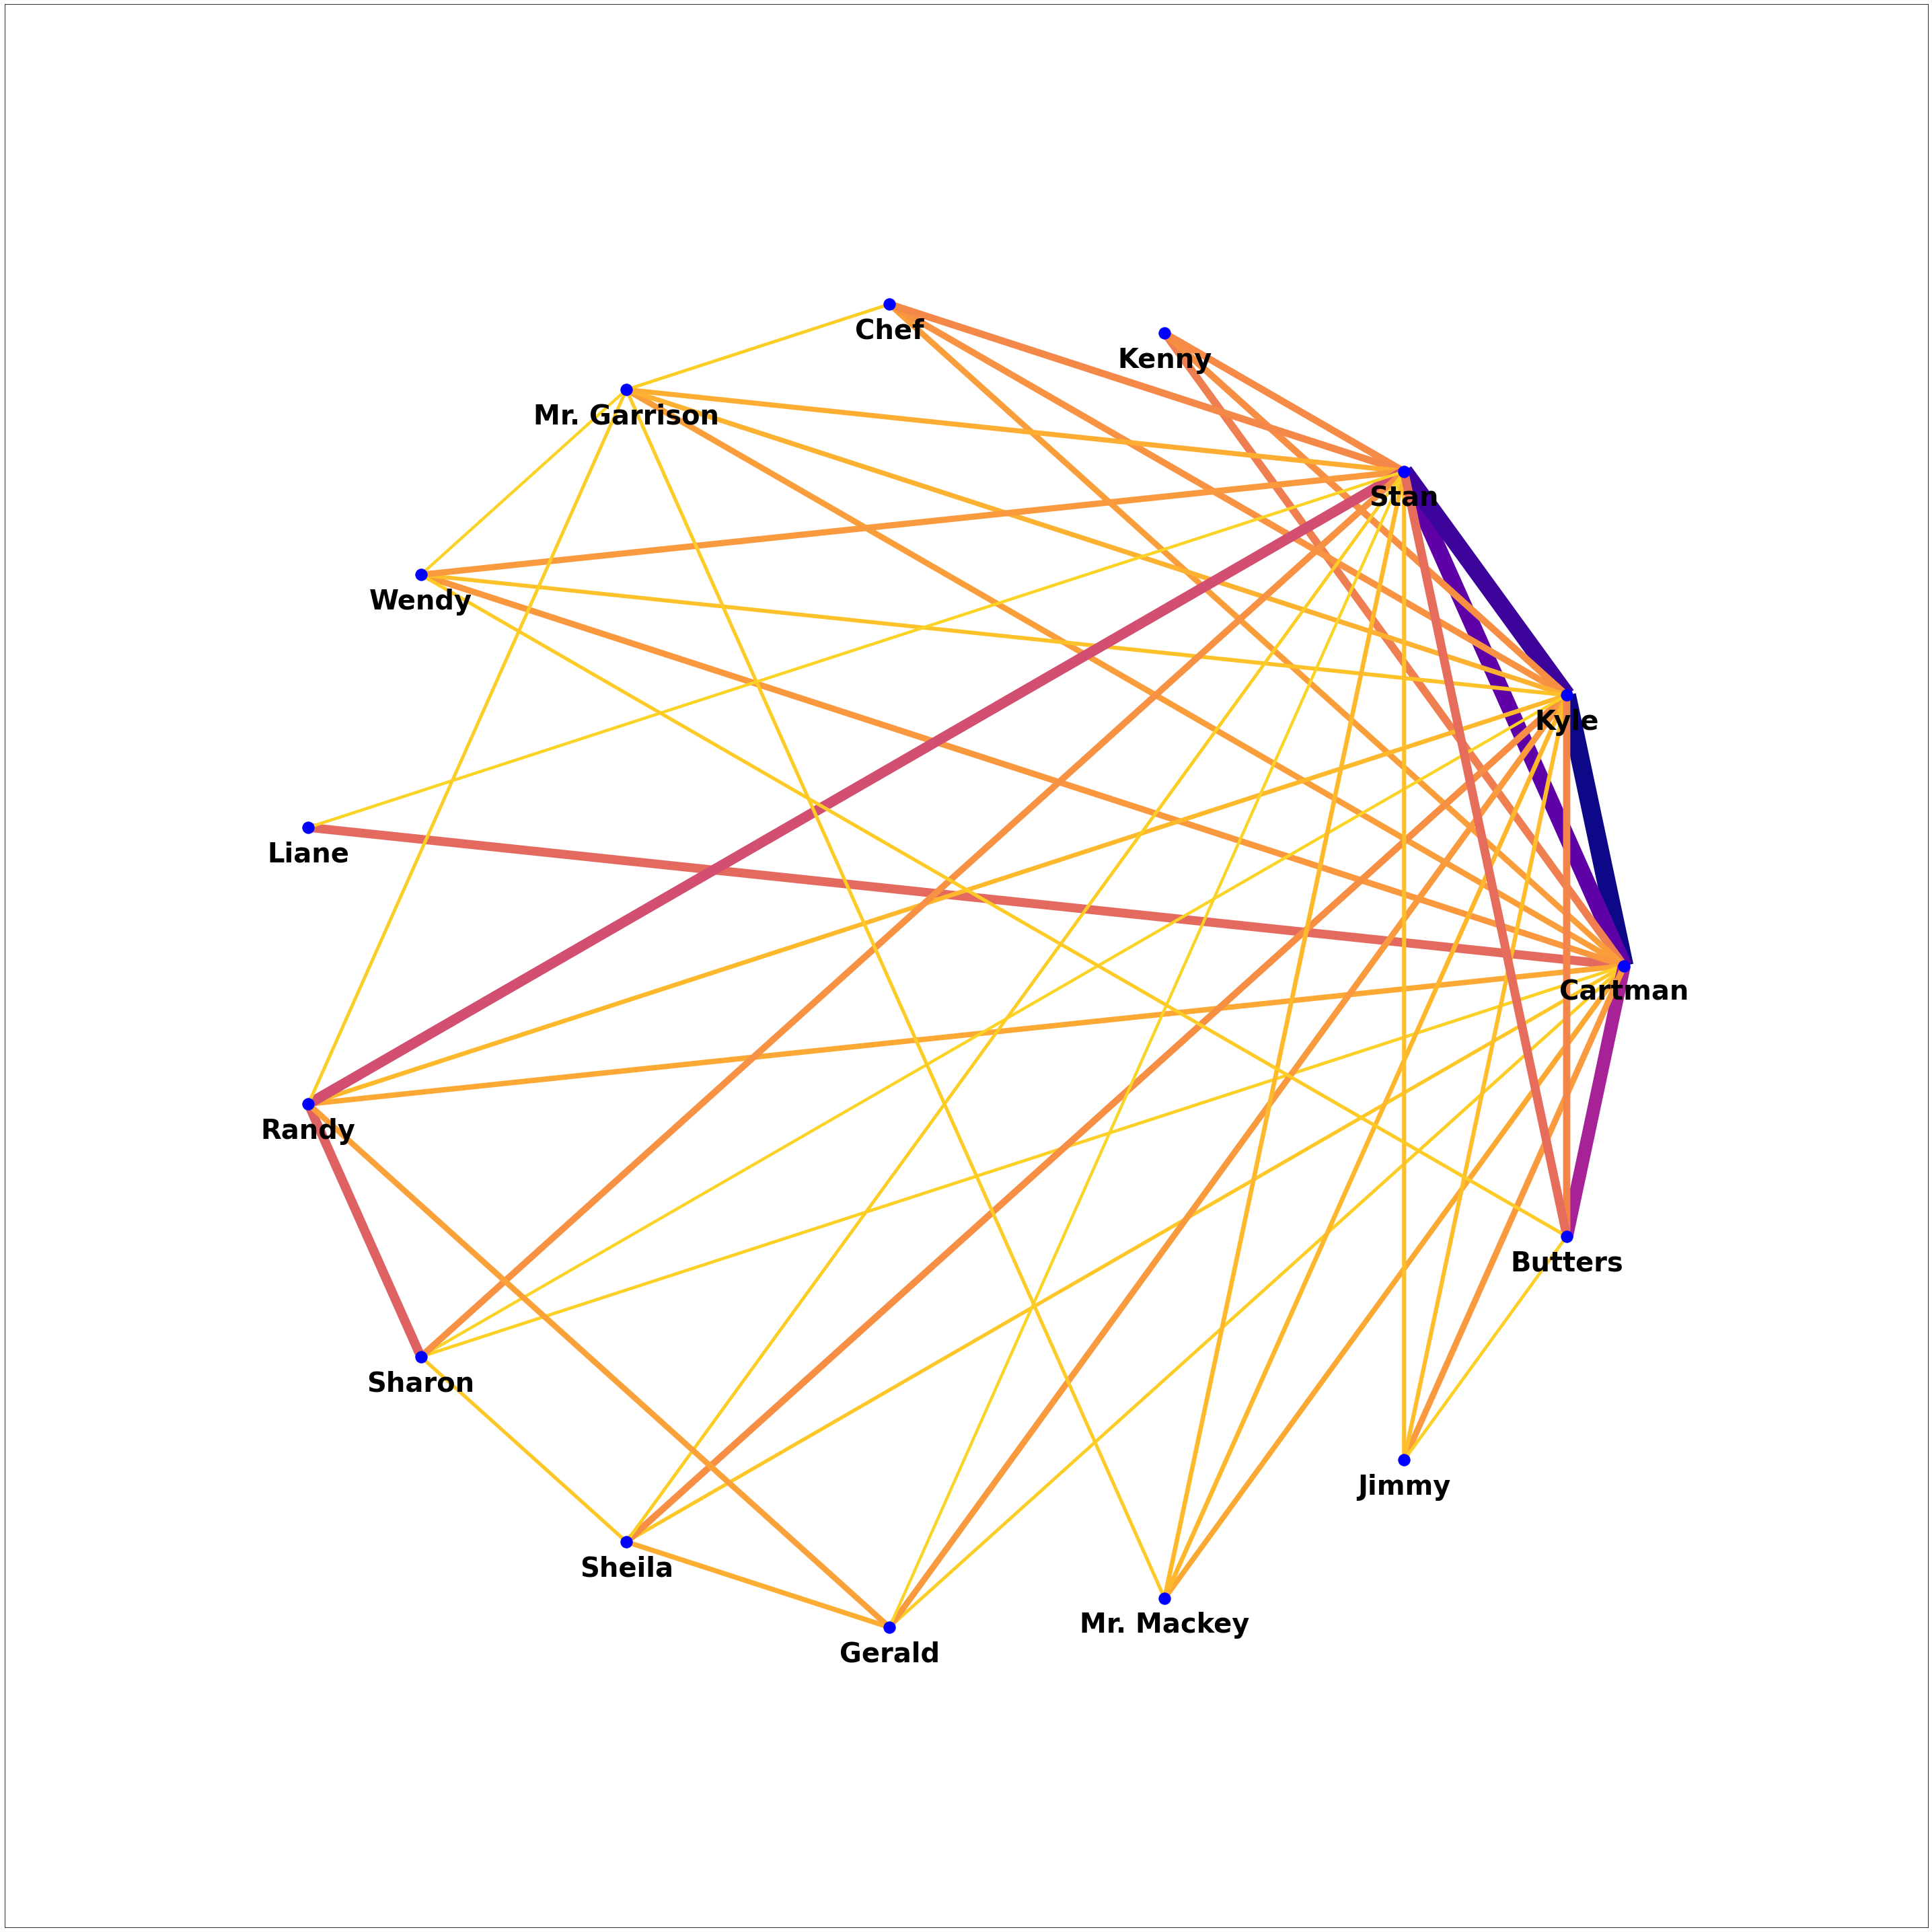

In [40]:
# make absolute interaction graph
plt.figure(figsize=(40,40))

pos = nx.circular_layout(G) 

edges = G.edges()
colors = [G[u][v]['weight']**0.5 for u,v in edges]
weights = [G[u][v]['weight']**0.4 if G[u][v]['weight'] > 40 else 0 for u,v in edges]

cmap = matplotlib.cm.get_cmap('plasma_r')
nx.draw_networkx(G, pos, width=weights, edge_color=colors, node_color="blue", edge_cmap=cmap, with_labels=False)

labels_pos = {name:[pos_list[0], pos_list[1]-0.04] for name, pos_list in pos.items()}
nx.draw_networkx_labels(G, labels_pos, font_size=40, font_family="sans-serif", font_color="#000000", font_weight="bold")

ax = plt.gca()
ax.margins(0.25)
plt.axis("equal")
plt.tight_layout()
plt.savefig("soutpark_interaction")

In [10]:
# compute interactions relative
relative_G = nx.MultiDiGraph()
for character in main_characters:
    character_edges = []
    total_weight = 0
    for edge in G.edges.data():
        c1 = edge[0]
        c2 = edge[1]
        weight = edge[2]["weight"]
        if c1 == character or c2 == character:
            character_edges.append(edge)
            total_weight += weight


    for edge in character_edges:
        c1 = edge[0]
        c2 = edge[1]
        weigth = edge[2]["weight"]

        other_character = c2 if c1 == character else c1
        relative_G.add_edge(character, other_character, weight=weigth/total_weight)
    
relative_A = np.array(nx.to_numpy_matrix(relative_G).tolist())
relative_A[relative_A < 0.05] = 0 # remove small interactions

# scale back to 1
row_sums = np.sum(relative_A, axis=1)
for row in range(len(relative_A)):
    row_sum = row_sums[row]
    for col in range(len(relative_A)):
        relative_A[row, col] = relative_A[row, col] / row_sum


In [11]:
# make chord diagram
# with inspiration from https://plotly.com/python/v3/filled-chord-diagram/

def check_data(data_matrix):
    L, M = data_matrix.shape
    if L != M:
        raise ValueError('Data array must have (n,n) shape')
    return L

L = check_data(relative_A)

PI = np.pi

def moduloAB(x, a, b): #maps a real number onto the unit circle identified with 
                       #the interval [a,b), b-a=2*PI
        if a >= b:
            raise ValueError('Incorrect interval ends')
        y = (x - a) % (b - a)
        return y + b if y < 0 else y + a

def test_2PI(x):
    return 0 <= x < 2 * PI

row_sum = [np.sum(relative_A[k,:]) for k in range(L)]

#set the gap between two consecutive ideograms
gap = 2 * PI * 0.005
ideogram_length = 2 * PI * np.asarray(row_sum) / sum(row_sum) - gap * np.ones(L)

def get_ideogram_ends(ideogram_len, gap):
    ideo_ends = []
    left = 0
    for k in range(len(ideogram_len)):
        right = left + ideogram_len[k]
        ideo_ends.append([left, right])
        left = right + gap
    return ideo_ends

ideo_ends = get_ideogram_ends(ideogram_length, gap)

def make_ideogram_arc(R, phi, a = 50):
    # R is the circle radius
    # phi is the list of ends angle coordinates of an arc
    # a is a parameter that controls the number of points to be evaluated on an arc
    if not test_2PI(phi[0]) or not test_2PI(phi[1]):
        phi = [moduloAB(t, 0, 2*PI) for t in phi]
    length = (phi[1]-phi[0])% 2*PI
    nr = 5 if length <= PI/4 else int(a*length/PI)

    if phi[0] < phi[1]:
        theta = np.linspace(phi[0], phi[1], nr)
    else:
        phi = [moduloAB(t, -PI, PI) for t in phi]
        theta = np.linspace(phi[0], phi[1], nr)
    return R * np.exp(1j * theta)

z = make_ideogram_arc(1.3, [11*PI/6, PI/17])

labels = main_characters

cmap = matplotlib.cm.get_cmap('RdYlGn')
ideo_colors = []
for i in range(15):
    ideo_colors.append(matplotlib.colors.to_hex(cmap(1. * np.sqrt(i) / np.sqrt(15))))

def map_data(data_matrix, row_value, ideogram_length):
    mapped = np.zeros(data_matrix.shape)
    for j  in range(L):
        mapped[:, j] = ideogram_length*data_matrix[:,j]/row_value
    return mapped

mapped_data = map_data(relative_A, row_sum, ideogram_length)

idx_sort = np.argsort(mapped_data, axis=1)

def make_ribbon_ends(mapped_data, ideo_ends,  idx_sort):
    L = mapped_data.shape[0]
    ribbon_boundary = np.zeros((L,L+1))
    for k in range(L):
        start = ideo_ends[k][0]
        ribbon_boundary[k][0] = start
        for j in range(1,L+1):
            J = idx_sort[k][j-1]
            ribbon_boundary[k][j] = start+mapped_data[k][J]
            start = ribbon_boundary[k][j]
    return [[(ribbon_boundary[k][j],ribbon_boundary[k][j+1] ) for j in range(L)] for k in range(L)]

ribbon_ends=make_ribbon_ends(mapped_data, ideo_ends,  idx_sort)

def control_pts(angle, radius):
    #angle is a  3-list containing angular coordinates of the control points b0, b1, b2
    #radius is the distance from b1 to the  origin O(0,0) 

    if len(angle) != 3:
        raise InvalidInputError('angle must have len =3')
    b_cplx=np.array([np.exp(1j*angle[k]) for k in range(3)])
    b_cplx[1]=radius*b_cplx[1]
    return zip(b_cplx.real, b_cplx.imag)

def ctrl_rib_chords(l, r, radius):
    # this function returns a 2-list containing control poligons of the two quadratic Bezier
    #curves that are opposite sides in a ribbon
    #l (r) the list of angular variables of the ribbon arc ends defining 
    #the ribbon starting (ending) arc 
    # radius is a common parameter for both control polygons
    if len(l) != 2 or len(r) != 2:
        raise ValueError('the arc ends must be elements in a list of len 2')
    return [control_pts([l[j], (l[j] + r[j])/2, r[j]], radius) for j in range(2)]

ribbon_color = [L * [ideo_colors[k]] for k in range(L)]

def make_q_bezier(b):# defines the Plotly SVG path for a quadratic Bezier curve defined by the 
                     #list of its control points
    b = list(b)
    if len(b) != 3:
        raise valueError('control poligon must have 3 points')
    A, B, C = b
    return 'M ' + str(A[0]) + ','  + str(A[1]) + ' ' + 'Q ' + \
                str(B[0]) + ', ' + str(B[1]) +  ' ' + \
                str(C[0]) + ', ' + str(C[1])


def make_ribbon_arc(theta0, theta1):

    if test_2PI(theta0) and test_2PI(theta1):
        if theta0 < theta1:
            theta0 = moduloAB(theta0, -PI, PI)
            theta1 = moduloAB(theta1, -PI, PI)
            if theta0 * theta1 > 0:
                raise ValueError('incorrect angle coordinates for ribbon')

        nr = int(40 * (theta0 - theta1) / PI)
        if nr <= 2: nr = 3
        theta = np.linspace(theta0, theta1, nr)
        pts = np.exp(1j * theta)# points on arc in polar complex form

        string_arc = ''
        for k in range(len(theta)):
            string_arc += 'L ' + str(pts.real[k]) + ', ' + str(pts.imag[k]) + ' '
        return string_arc
    else:
        raise ValueError('the angle coordinates for an arc side of a ribbon must be in [0, 2*pi]')

make_ribbon_arc(np.pi/3, np.pi/6)

def make_layout(plot_size):
    axis=dict(showline = False, # hide axis line, grid, ticklabels and  title
          zeroline = False,
          showgrid = False,
          showticklabels = False,
          title = ''
          )

    return go.Layout(
                  xaxis=dict(axis),
                  yaxis=dict(axis),
                  showlegend=False,
                  width=plot_size,
                  height=plot_size,
                  margin=dict(t=25, b=25, l=25, r=25),
                  hovermode='closest',
                  shapes=[]# to this list one appends below the dicts defining the ribbon,
                           #respectively the ideogram shapes
                 )

def make_ideo_shape(path, line_color, fill_color):
    #line_color is the color of the shape boundary
    #fill_collor is the color assigned to an ideogram
    return  dict(
                    line = dict(color = line_color, width = 0.45),
                    path = path,
                    type='path',
                    fillcolor=fill_color,
                    layer='below'
        )

def make_ribbon(l, r, line_color, fill_color, radius=0.2):
    #l=[l[0], l[1]], r=[r[0], r[1]]  represent the opposite arcs in the ribbon 
    #line_color is the color of the shape boundary
    #fill_color is the fill color for the ribbon shape
    poligon = ctrl_rib_chords(l, r, 0.1)
    b,c = poligon
    b = list(b)
    c = list(c)

    return  dict(
        line=dict(color=line_color, width=0.5),
        path =  make_q_bezier(b) + make_ribbon_arc(r[0], r[1]) +
                make_q_bezier(c[::-1]) + make_ribbon_arc(l[1], l[0]),
        type = 'path',
        fillcolor = fill_color,
        layer = 'below'
        )

def make_self_rel(l, line_color, fill_color):
    #radius is the radius of Bezier control point b_1
    b = control_pts([l[0], (l[0] + l[1])/2, l[1]], 1)
    return  dict(
        line = dict(color = line_color, width=0.5),
        path=  make_q_bezier(b)+make_ribbon_arc(l[1], l[0]),
        type='path',
        fillcolor=fill_color,
        layer='below'
        )

def invPerm(perm):
    # function that returns the inverse of a permutation, perm
    inv = [0] * len(perm)
    for i, s in enumerate(perm):
        inv[s] = i
    return inv

layout = make_layout(400)

shapes = []
for k in range(L):
    sigma = idx_sort[k]
    sigma_inv = invPerm(sigma)
    for j in range(k, L):
        if (relative_A[k][j] == 0) and (relative_A[j][k] == 0): continue

        eta = idx_sort[j]
        eta_inv = invPerm(eta)
        l = ribbon_ends[k][sigma_inv[j]]
        
        if j == k:
            shapes.append(make_self_rel(l, 'rgb(175,175,175)', ideo_colors[k]))

        else:
            r=ribbon_ends[j][eta_inv[k]]

            r=(r[1], r[0])#IMPORTANT!!!  Reverse these arc ends because otherwise you get
                          # a twisted ribbon
            #append the ribbon shape
            shapes.append(make_ribbon(l, r, 'rgb(175,175,175)' , ribbon_color[k][j]))

ideograms = []
for k in range(len(ideo_ends)):
    z = make_ideogram_arc(1.05, ideo_ends[k])
    zi = make_ideogram_arc(1.0, ideo_ends[k])
    m = len(z)
    n = len(zi)
    ideograms.append(
        go.Scatter(
            x=z.real,
            y=z.imag,
            mode='lines',
            line=dict(color=ideo_colors[k], shape='spline', width=0.25),
            text=labels[k],
            hoverinfo='text'
            )
        )


    path = 'M '
    for s in range(m):
        path += str(z.real[s]) + ', ' + str(z.imag[s]) + ' L '

    Zi = np.array(zi.tolist()[::-1])

    for s in range(m):
        path += str(Zi.real[s]) + ', ' + str(Zi.imag[s]) + ' L '
    path += str(z.real[0]) + ' ,' + str(z.imag[0])

    shapes.append(make_ideo_shape(path,'rgb(150,150,150)' , ideo_colors[k]))


data = go.Data(ideograms)
fig = go.Figure(data=data, layout=layout)

fig.update_layout(shapes=shapes)
fig.update_layout(
    autosize=False,
    width=750, # somehow not quite circular with height/width same
    height=800,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
    )

#plotly.offline.plot(fig, filename='south_park_interaction_relative')